Simple Tag
https://www.pettingzoo.ml/mpe/simple_tag

> This is a predator-prey environment. Good agents (green) are faster and receive a negative reward for being hit by adversaries (red) (-10 for each collision). Adversaries are slower and are rewarded for hitting good agents (+10 for each collision). Obstacles (large black circles) block the way. By default, there is 1 good agent, 3 adversaries and 2 obstacles.

Baseline agent algorithm with experience replay buffer

In [1]:
import os
import time
import enum
import math
import random
import collections
import statistics

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
import torch.nn
import torch.nn.functional as F

class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self

class TimeDelta(object):
    def __init__(self, delta_time):
        """Convert time difference in seconds to days, hours, minutes, seconds.
        
        Parameters
        ==========
        delta_time : float
            Time difference in seconds.
        """
        self.fractional, seconds = math.modf(delta_time)
        seconds = int(seconds)
        minutes, self.seconds = divmod(seconds, 60)
        hours, self.minutes = divmod(minutes, 60)
        self.days, self.hours = divmod(hours, 24)
    
    def __repr__(self):
        return f"{self.days}-{self.hours:02}:{self.minutes:02}:{self.seconds + self.fractional:02}"
        
from pettingzoo.mpe import simple_tag_v2
from pettingzoo.utils import random_demo

Arguments in instantiate environment.

- num_good: number of good agents
- num_adversaries: number of adversaries
- num_obstacles: number of obstacles
- max_cycles: number of frames (a step for each agent) until game terminates
- continuous_actions: Whether agent action spaces are discrete(default) or continuous

In [2]:
env = simple_tag_v2.env(
    num_good=1,
    num_adversaries=1,
    num_obstacles=0,
    max_cycles=300,
    continuous_actions=False
).unwrapped

### What are the environment parameters?

Adversaries (red) capture non-adversary (green). The map is a 2D grid and everything is initialized in the region [-1, +1]. There doesn't seem to be position clipping for out of bounds, but non-adversary agent are penalized for out of bounds.
Agent's observation is a ndarray vector of concatenated data in the following order:

1. current velocity (2,)
2. current position (2,)
3. relative position (2,) of each landmark
4. relative position (2,) of each other agent
5. velocity (2,) of each other non-adversary agent

When there are 3 adverseries and 3 non-adversaries, then advarsary observation space is 24 dimensional and non-advarsary observation space is 22 dimensional.

The environment is sequential. Agents move one at a time. Agents are either `adversary_*` for adversary or `agent_*` for non-adversary.

Actions:

- 0 is NOP
- 1 is go left
- 2 is go right
- 3 is go down
- 4 is go up

### How to train the agents?

- Use the differental inter-agent learning (DIAL) algorithm.
- Use parameter sharing for DAIL agents. Separate parameter sets for adversary agents and good agents.
- It's not entirely clear the authors accumulate gradients for differentiable communication, but it 

Messages are vectors. Length 4, 5 should work.

Concatenate the messages from all the actors and add them to the message input for the current agent.

The names of agents are: 
adversary_0 adversary_1 adversary_2 agent_0 agent_1 agent_2

In [3]:
env.reset()

In [4]:
def get_agent_counts():
    all_agents = 0
    adversaries = 0
    for agent in env.world.agents:
        all_agents += 1
        adversaries += 1 if agent.adversary else 0
    good_agents = all_agents - adversaries
    return (adversaries, good_agents)

def process_config(config):
    for k, v in config.common.items():
        config.adversary[k] = v
        config.agent[k] = v

n_adversaries, n_good_agents = get_agent_counts()
config = AttrDict(
    discount = 0.99,
    epsilon = 0.05,
    n_episodes=600,
    batch_size=16,
    update_target_interval=32,
    report_interval=64,
    clip_grad_norm=2.,
    lr=0.005,
    device=torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    common=AttrDict(
        message_size=4,
        hidden_size=128,
        n_actions=env.action_space(env.agent_selection).n,
        n_rnn_layers=2,
        apply_bn=False,
    ),
    adversary=AttrDict(
        n_agents=n_adversaries,
        observation_shape=env.observation_space("adversary_0").shape

    ),
    agent=AttrDict(
        n_agents=n_good_agents,
        observation_shape=env.observation_space("agent_0").shape
    )
)
process_config(config)
config

{'discount': 0.99,
 'epsilon': 0.05,
 'n_episodes': 600,
 'batch_size': 16,
 'update_target_interval': 32,
 'report_interval': 64,
 'clip_grad_norm': 2.0,
 'lr': 0.005,
 'device': device(type='cuda'),
 'common': {'message_size': 4,
  'hidden_size': 128,
  'n_actions': 5,
  'n_rnn_layers': 2,
  'apply_bn': False},
 'adversary': {'n_agents': 1,
  'observation_shape': (8,),
  'message_size': 4,
  'hidden_size': 128,
  'n_actions': 5,
  'n_rnn_layers': 2,
  'apply_bn': False},
 'agent': {'n_agents': 1,
  'observation_shape': (6,),
  'message_size': 4,
  'hidden_size': 128,
  'n_actions': 5,
  'n_rnn_layers': 2,
  'apply_bn': False}}

In [5]:
class SimpleTagNet(torch.nn.Module):
    """NN Model for the agents. Both good agents and adversaries use this model."""
        
    def __init__(self, config, agent_type):
        super().__init__()
        # self.config = config
        self.device      = config.device
        self.observation_size = math.prod(config[agent_type].observation_shape)
        self.n_actions   = config[agent_type].n_actions
        self.hidden_size = config[agent_type].hidden_size
        self.output_mlp = torch.nn.Sequential(
            torch.nn.Linear(self.observation_size, self.hidden_size),
            torch.nn.ReLU(inplace=True),
            torch.nn.Linear(self.hidden_size, self.n_actions)
        )
    
    def forward(self, observation):
        """Apply DQN to episode step.
        
        Parameters
        ==========
        observation : ndarray
            The observation vector obtained from the environment.
        
        Returns
        =======
        torch.Tensor
            Vector of Q-value associated with each action.
        """
        observation = torch.tensor(observation, dtype=torch.float, device=self.device)
        Q = self.output_mlp(observation)
        return Q

In [10]:
def choose_action(config, agent_type, Q, is_val=False):
    if not is_val and random.random() < config.epsilon:
        return random.randrange(config[agent_type].n_actions)
    else:
        return torch.argmax(Q).item()

def run_episode(config, adversary_net, should_render=False, is_val=False):
    """Run one episodes.
    
    inputs consist of observation, message (backprop), hidden (backprop) indexed by agent
    outputs consist of action, q-value of action (backprop), reward, done indexed by (step, agent)
    
    Returns
    =======
    AttrDict
        Contains episode metrics:
        - steps : number of steps. All agents take an action at each step.
        - reward : episodic rewards indexed by ('adversary', 'agent').
        - step_records : list of quantities produced indiced by step, ('adversary', 'agent'), agent index.
          Each step record has:
            + observation
            + Q
            + reward
            + done
        - loss : contains episodic losses indexed by ('adversary', 'agent'). To be updated by train_agents()
    """
    episode = AttrDict(
        steps=0,
        reward=AttrDict(adversary=0, agent=0),
        step_records=[],
        loss=AttrDict(adversary=0, agent=0)
    )
    n_agents = config.adversary.n_agents + config.agent.n_agents
    step_record = None
    
    env.reset()
    for agent_step_idx, agent_name in enumerate(env.agent_iter()):
        if should_render:
            env.render()
        if agent_step_idx % n_agents == 0:
            episode.steps += 1
            step_record = AttrDict(adversary={}, agent={})
            episode.step_records.append(step_record)
            
        obs_curr, reward, done, _ = env.last()
        agent_type, agent_idx = agent_name.split("_")
        agent_idx = int(agent_idx)
        if done:
            step_record[agent_type][agent_idx] = AttrDict(
                observation=obs_curr,
                action=None,
                Q=None,
                reward=reward,
                done=done,
            )
            env.step(None)
            continue
        if agent_type == "agent":
            env.step(0)
            step_record[agent_type][agent_idx] = AttrDict(
                observation=obs_curr,
                action=0,
                Q=None,
                reward=reward,
                done=done,
            )
            continue

        Q_curr = adversary_net(obs_curr)
        action = choose_action(config, agent_type, Q_curr, is_val=is_val)
        env.step(action)
        step_record[agent_type][agent_idx] = AttrDict(
            # inputs to network
            observation=obs_curr,
            # outputs of network / inputs to environment
            action=action,
            Q=Q_curr,
            # output of environment
            reward=reward,
            done=done,
        )
        episode.reward[agent_type] += reward
    
    return episode

def train_agents(config, batch, adversary_net,
                 adversary_target_net,
                 adversary_optimizer):
    """Compute loss of episode and update agent weights.
    """
    device = config.device
    discount = torch.tensor(config.discount, dtype=torch.float, device=device)
    adversary_loss = torch.tensor(0., device=device)
    for episode in batch:
        for step_idx in range(episode.steps):
            for agent_idx in episode.step_records[step_idx].adversary.keys():
                curr_record = episode.step_records[step_idx].adversary[agent_idx]
                if curr_record.done:
                    # agent is done at this step
                    continue
                next_record = episode.step_records[step_idx + 1].adversary[agent_idx]
                r = torch.tensor(next_record.reward, dtype=torch.float, device=device)
                y = None
                if next_record.done:
                    # agent terminates at next step
                    y = r
                else:
                    next_o = next_record.observation
                    with torch.no_grad():
                        target_Q = adversary_target_net(next_o)
                        max_target_Q = torch.max(target_Q)
                        y = r + discount*max_target_Q
                u = curr_record.action
                Q_u = curr_record.Q[u]
                adversary_loss = adversary_loss + torch.pow(y - Q_u, 2.)
    
    n_adversary = torch.tensor(config.adversary.n_agents, dtype=torch.float, device=device)
    n_agent = torch.tensor(config.agent.n_agents, dtype=torch.float, device=device)
    bs = torch.tensor(config.batch_size, dtype=torch.float, device=device)
    adversary_loss = adversary_loss / (bs * n_adversary)
    adversary_optimizer.zero_grad()
#     torch.nn.utils.clip_grad_norm_(adversary_net.parameters(), config.clip_grad_norm)
#     torch.nn.utils.clip_grad_norm_(agent_net.parameters(), config.clip_grad_norm)
    adversary_loss.backward()
    adversary_optimizer.step()
    episode.loss = AttrDict(adversary=adversary_loss.item(), agent=0.)
    

def train(config):
    """
    - Use parameter sharing between agents of the same class.
    - Good agents use one RL model, adversaries use another RL model.
      Train the agents side by side.
    - Separate, disjoint communication channels for two classes of agents,
      maintained by a container to store the messages.
    """
    print("Training the agents...")
    os.makedirs("models/batched-baseline-test", exist_ok=True)
    t0 = time.time()
    device = config.device
    adversary_net = SimpleTagNet(config, "adversary").to(device)
    adversary_target_net = SimpleTagNet(config, "adversary").to(device)
    adversary_target_net.eval()
    print("Created the agent nets.")
    adversary_optimizer = torch.optim.SGD(adversary_net.parameters(), lr=config.lr)
    logger = AttrDict(
        episodic_losses=AttrDict(adversary=[], agent=[]),
        episodic_rewards=AttrDict(adversary=[], agent=[])
    )
    def update_targets():
        adversary_target_net.load_state_dict(adversary_net.state_dict())
    print("Initial update of target nets")
    update_targets()
    
    batch = []
    print("Beginning the episodes...")
    for episode_idx in range(config.n_episodes):
        # Run an episode
        episode = run_episode(config, adversary_net,
                              should_render=episode_idx % config.report_interval == 0 and episode_idx > 0)
        batch.append(episode)
        
        # Train on the episode
        if episode_idx % config.batch_size == 0 and episode_idx > 0:
            train_agents(config, batch, adversary_net,
                         adversary_target_net,
                         adversary_optimizer)
            batch = []
        
        # Logging the reward and los
        logger.episodic_losses.adversary.append(episode.loss.adversary)
        logger.episodic_losses.agent.append(episode.loss.agent)
        logger.episodic_rewards.adversary.append(episode.reward.adversary)
        logger.episodic_rewards.agent.append(episode.reward.agent)

        if episode_idx % config.update_target_interval == 0 and episode_idx > 0:
            # Update double network
            update_targets()
        
        if episode_idx % config.report_interval == 0 and episode_idx > 0:
            # Logging
            t1 = time.time()
            tdelta = TimeDelta(round(t1 - t0, 0))
            print(f"on episode {episode_idx} (time taken so far: {tdelta})")
            mean_loss_adversary = statistics.fmean(logger.episodic_losses.adversary[-config.report_interval:])
            mean_reward_adversary = statistics.fmean(logger.episodic_rewards.adversary[-config.report_interval:])
            mean_reward_agent = statistics.fmean(logger.episodic_rewards.agent[-config.report_interval:])
            print(f"     mean loss: adversary {mean_loss_adversary}")
            print(f"     mean reward: adversary {mean_reward_adversary}, agent {mean_reward_agent}")
            torch.save(
                adversary_net.state_dict(),
                f"models/batched-baseline-test/adversary-net-{episode_idx}.pth"
            )
    
    return adversary_net, logger


In [11]:
# train model
adversary_net, logger = train(config)

Training the agents...
Created the agent nets.
Initial update of target nets
Beginning the episodes...
on episode 64 (time taken so far: 0-00:00:13.0)
     mean loss: adversary 229249.30341261625
     mean reward: adversary 2.03125, agent 0.0
on episode 128 (time taken so far: 0-00:00:25.0)
     mean loss: adversary nan
     mean reward: adversary 0.9375, agent 0.0
on episode 192 (time taken so far: 0-00:00:37.0)
     mean loss: adversary nan
     mean reward: adversary 1.71875, agent 0.0
on episode 256 (time taken so far: 0-00:00:49.0)
     mean loss: adversary nan
     mean reward: adversary 0.625, agent 0.0
on episode 320 (time taken so far: 0-00:01:2.0)
     mean loss: adversary nan
     mean reward: adversary 1.40625, agent 0.0
on episode 384 (time taken so far: 0-00:01:15.0)
     mean loss: adversary nan
     mean reward: adversary 0.78125, agent 0.0


KeyboardInterrupt: 

In [7]:
adversary_net = SimpleTagNet(config, "adversary").to(config.device)
agent_net = SimpleTagNet(config, "agent").to(config.device)
adversary_net.load_state_dict(torch.load('./models/batched-baseline/adversary-net-448.pth'))
agent_net.load_state_dict(torch.load('./models/batched-baseline/agent-net-448.pth'))

<All keys matched successfully>

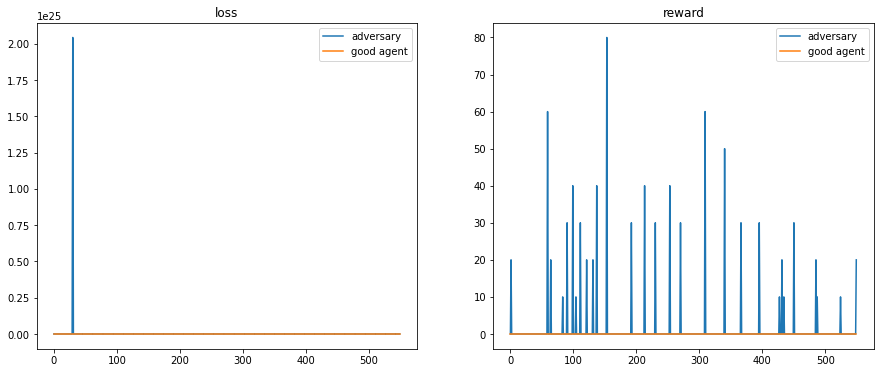

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
axes = axes.ravel()

axes[0].plot(logger.episodic_losses.adversary[50:], label="adversary")
axes[0].plot(logger.episodic_losses.agent[50:], label="good agent")
axes[0].set_title("loss")
axes[0].legend()

axes[1].plot(logger.episodic_rewards.adversary[50:], label="adversary")
axes[1].plot(logger.episodic_rewards.agent[50:], label="good agent")
axes[1].set_title("reward")
axes[1].legend()
None

In [8]:
def visualize(config, adversary_net):
    adversary_net.eval()
    with torch.no_grad():
        return run_episode(config, adversary_net, should_render=True, is_val=True)

episode = visualize(config, adversary_net)
print("episode steps", episode.steps)
print("episode rewards", *episode.reward.items())

episode steps 301
episode rewards ('adversary', 0.0) ('agent', 0)
